# Gamma Spectrum Energy Calibration

This notebook demonstrates how to calibrate gamma-ray spectra using natural background peaks.

**Common calibration peaks:**
- **Bi-214 (609 keV)**: Medium energy, usually strong in natural background
- **K-40 (1461 keV)**: High energy, ubiquitous in concrete, soil
- **Tl-208 (2615 keV)**: Very high energy, from Th-232 decay chain

**Workflow:**
1. Load your spectrum
2. Find prominent peaks
3. Identify calibration peaks
4. Calculate calibration
5. Apply and validate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from spectrum_calibration import *

# For inline plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## 1. Load Your Spectrum

Load your CNF file or any spectrum data. You need just the count array.

In [5]:
# Option A: Load from CNF file
from cnf_parser_standalone import read_cnf

#path = r"C:\Users\aliha\Downloads\2025-12-23"
#path = r"C:\Users\aliha\Downloads\2026-rooftop"
path = r'/home/dosenet/Dropbox/UCB Air Monitor/Data/Roof/current/2026/'
#path = r"C:\Users\aliha\Downloads\2025-12-19"
#filepath = r"C:\Users\aliha\Downloads\2025-04-22-rooftop\2025-04-22_17-13-40-733175.CNF"  # ← Change this to your file
filepath = path + r'2026-02-06_10-27-04-288495.CNF'
data = read_cnf(filepath, verbose=True)
counts = data['counts']

print(f"Loaded {len(counts)} channels")
print(f"Total counts: {np.sum(counts):.0f}")

Reading CNF file /home/dosenet/Dropbox/UCB Air Monitor/Data/Roof/current/2026/2026-02-06_10-27-04-288495.CNF
file size (bytes): 73728
Offsets - ACQ: 0x8a00, SAM: 0xf200, EFF: 0xfe00, ENC: 0x8a00, CHAN: 0x800
sample name:                                                                  
sample id:                                                                    
sample type:                  
sample unit:  @  Unit                                                        
user name:                                    
sample desc:                                                                                                                                                                                                                                                                  
New format detected (no PHA keyword)
Number of channels:  8192
Extracted start time from filename: 2026-02-06 10:27:04
New format timing: realtime=300.00s
Note: Livetime not found in file, using realtime as

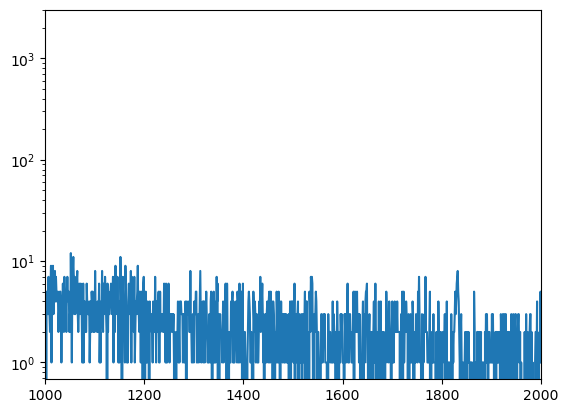

In [11]:
plt.plot(counts)
plt.yscale("log")
#plt.xlim(0,4500)
plt.xlim(1000,2000)
#plt.xlim(4000,4500)
#plt.xlim(7000,8000)
plt.show()


## 2. Find Prominent Peaks

This will identify and plot the most prominent peaks in your spectrum.

/home/dosenet/radwatch-airmonitor/image_scripts/spectrum_calibration.py:221: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='best', fontsize=9)


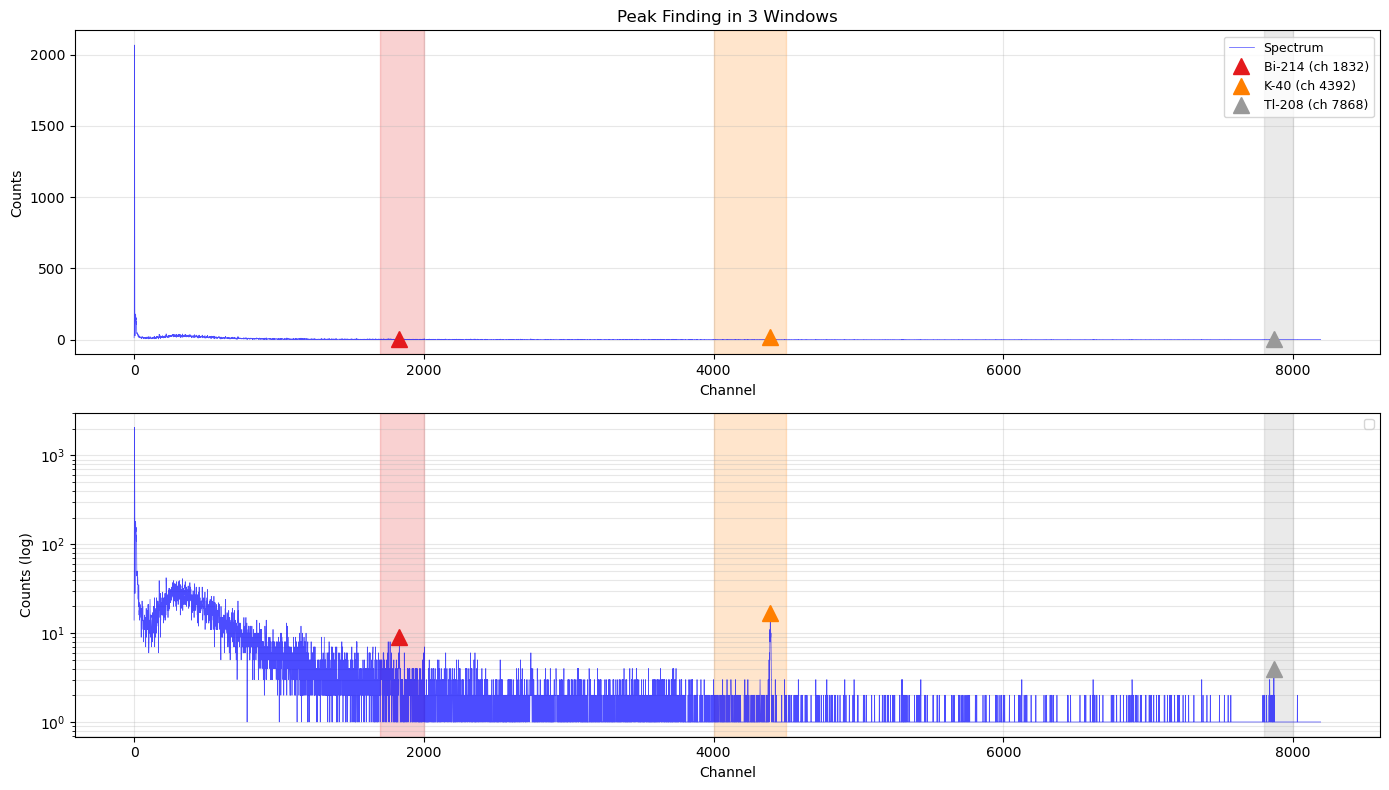


Window                    Channel    Counts      
--------------------------------------------------
Bi-214                    1832       8           
K-40                      4392       16          
Tl-208                    7868       3           


In [12]:
#windows = [
#    (1800, 2000, 'Bi-214'),   # Look for peak between channels 280-330
#    (4000, 4500, 'K-40'),     # Look for peak between channels 700-760
#    (7800, 8000, 'Tl-208')  # Look for peak between channels 1280-1340
#]

windows = [
    (1700, 2000, 'Bi-214'),   # Look for peak between channels 280-330
    (4000, 4500, 'K-40'),     # Look for peak between channels 700-760
    (7800, 8000, 'Tl-208')  # Look for peak between channels 1280-1340
]

expected_energies = [609.3, 1460.8, 2614.5]

peak_results = find_peaks_in_windows(counts, windows, plot=True)

#cal, energies, info, peaks = calibrate_from_windows(
#    counts, windows, expected_energies
#)

## 3. Get Calibration Suggestions (Optional)

This can help you identify which peaks might be which energies.

In [11]:
suggest_calibration_peaks(counts)


Possible peak identifications:
Channel    Counts       Possible Identity              Approx Energy
----------------------------------------------------------------------

To use these suggestions:
  1. Examine the plotted spectrum to identify strong peaks
  2. Match peak channels to expected energies
  3. Create calibration_points = [(ch1, E1), (ch2, E2), ...]
  4. Run: cal, info = calibrate_spectrum(calibration_points)


## 4. Specify Calibration Points

Look at the peak list above and identify which channels correspond to known energies.

**You need at least 2 points for linear calibration, 3 for quadratic.**

In [45]:
# Example: Replace these channel numbers with your actual peak channels
calibration_points = [
    (305, 609.3),    # Bi-214 at channel 305 → 609 keV
    (731, 1460.8),   # K-40 at channel 731 → 1461 keV  
    (1308, 2614.5),  # Tl-208 at channel 1308 → 2615 keV
]

# Note: These are just examples! You must identify the actual channels 
# from your spectrum using the peak finding results above.

## 5. Calculate and Apply Calibration

This does everything: calculates calibration, applies it, and shows results.

FINDING PEAKS IN WINDOWS


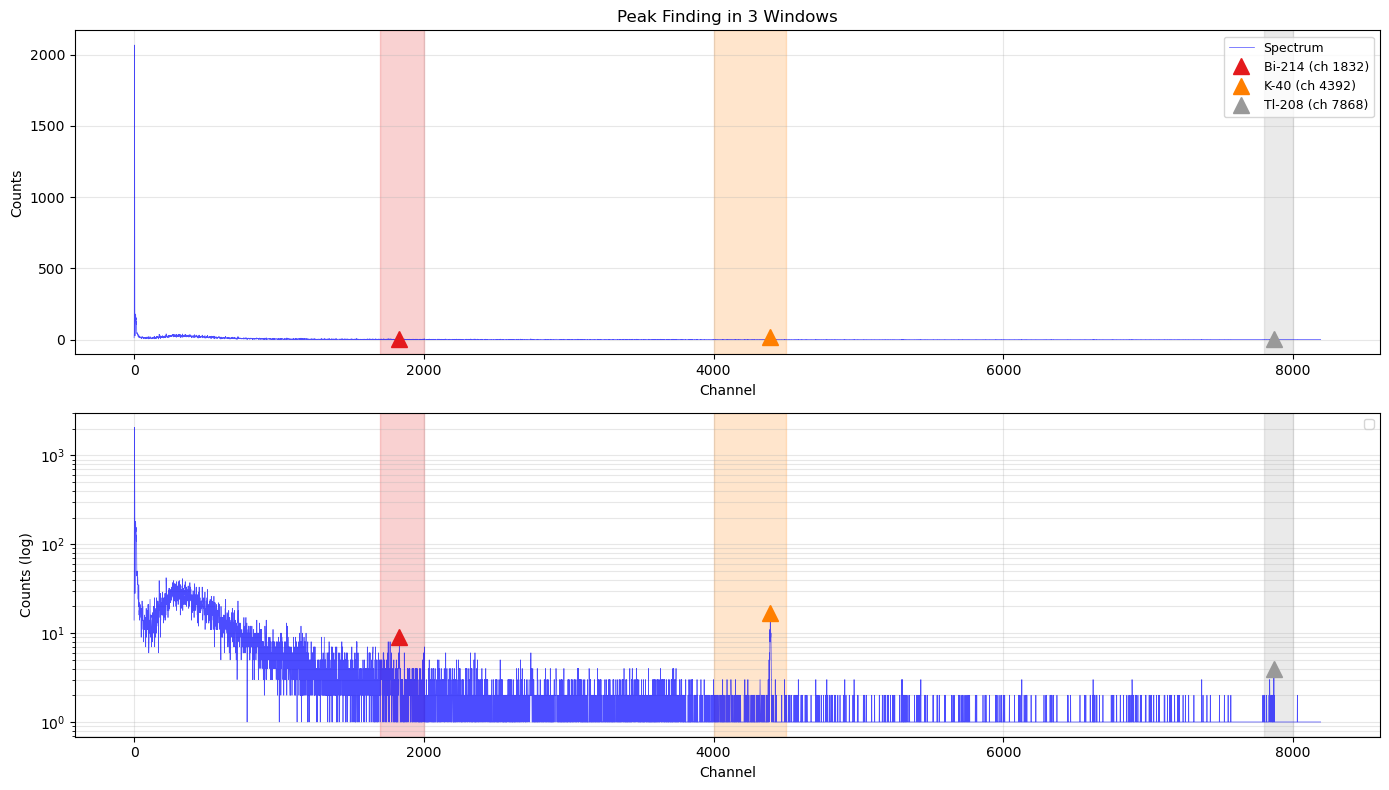


Window                    Channel    Counts      
--------------------------------------------------
Bi-214                    1832       8           
K-40                      4392       16          
Tl-208                    7868       3           

CALCULATING CALIBRATION
CALIBRATION SUMMARY

Coefficients:
  c0 = 1.129543
  c1 = 0.332189283
  c2 = 0.000000000000
  c3 = 0.000000000000000

Calibration equation:
  Energy (keV) = 1.129543 + 0.332189283×ch

Fit quality:
  RMS error: 0.493 keV
  Calibration points: 3
  Polynomial order: 1

To use in code:
  calibration = [np.float64(1.1295429307901368), np.float64(0.3321892826573677), 0.0, 0.0]
  energies = apply_calibration(counts, calibration)


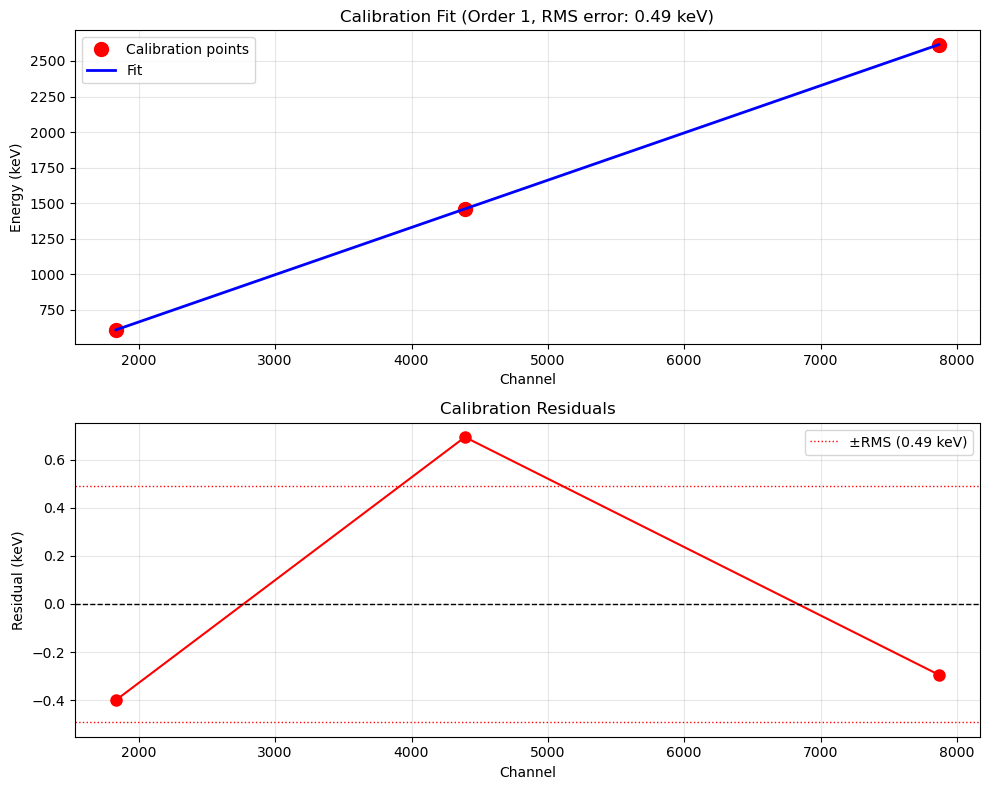


Peak #   Channel    Expected     Fitted       Error     
----------------------------------------------------
1        1832       609.3        609.7             +0.40
2        4392       1460.8       1460.1            -0.70
3        7868       2614.5       2614.8            +0.29


In [13]:
# Quick calibration (all-in-one)
#calibration, energies, fit_info = quick_calibrate(
#    counts, 
#    calibration_points, 
#    order=1,  # 1=linear, 2=quadratic
#    plot=True
#)

cal, energies, info, peaks = calibrate_from_windows(
    counts, windows, expected_energies
)

## 7. Save Results

In [14]:
cal

[np.float64(1.1295429307901368), np.float64(0.3321892826573677), 0.0, 0.0]

In [15]:
# Save calibrated spectrum to CSV
output_file = 'calibrated_spectrum.csv'
np.savetxt(output_file, 
           np.column_stack([energies, counts]),
           delimiter=',', 
           header='Energy(keV),Counts', 
           comments='')
print(f"Saved to {output_file}")

Saved to calibrated_spectrum.csv


In [16]:
# Save calibration coefficients
c0, c1, c2, c3 = cal
with open('calibration_coefficients.txt', 'w') as f:
    f.write(f"c0 = {c0:.6f}\n")
    f.write(f"c1 = {c1:.9f}\n")
    f.write(f"c2 = {c2:.12f}\n")
    f.write(f"c3 = {c3:.15f}\n")
    f.write(f"\nEnergy (keV) = {c0:.6f} + {c1:.9f}*channel + {c2:.12f}*channel^2\n")
    f.write(f"\nRMS error: {info['rms_error']:.3f} keV\n")
print("Saved calibration coefficients")

Saved calibration coefficients


## 8. Use Calibration for Analysis

Now you can use the calibrated energy axis for further analysis:

In [ ]:
# Example: Find peak at specific energy
target_energy = 661.7  # Cs-137 peak
window = 10  # keV window

mask = (energies >= target_energy - window) & (energies <= target_energy + window)
peak_counts = counts[mask]
peak_energies = energies[mask]

print(f"Peak region around {target_energy} keV:")
print(f"  Total counts: {np.sum(peak_counts):.0f}")
print(f"  Max counts: {np.max(peak_counts):.0f} at {peak_energies[np.argmax(peak_counts)]:.1f} keV")

# Plot just this region
plt.figure(figsize=(10, 4))
plt.plot(peak_energies, peak_counts, 'b-', linewidth=1.5)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title(f'Peak at {target_energy} keV')
plt.grid(True, alpha=0.3)
plt.show()

## Tips and Troubleshooting

### If peaks are hard to identify:
- Try adjusting `min_height` and `min_prominence` in `find_peaks_for_calibration()`
- Look at the log-scale plot - it shows weak peaks better
- Use the suggestions from `suggest_calibration_peaks()`

### For better calibration accuracy:
- Use peaks spread across the energy range
- Use at least 3 points for quadratic fit (`order=2`)
- Strong, isolated peaks work best
- Check that RMS error is small (< 5 keV for good calibration)

### Common natural background peaks:
```python
REFERENCE_PEAKS = {
    'Bi-214 (609)': 609.3,
    'Bi-214 (1120)': 1120.3,
    'Bi-214 (1764)': 1764.5,
    'K-40': 1460.8,
    'Tl-208 (583)': 583.2,
    'Tl-208 (2615)': 2614.5,
}
```

### If you have calibration sources:
```python
CALIBRATION_SOURCES = {
    'Cs-137': 661.7,
    'Co-60 (1173)': 1173.2,
    'Co-60 (1332)': 1332.5,
    'Na-22 (511)': 511.0,
    'Na-22 (1275)': 1274.5,
}
```